<a href="https://colab.research.google.com/github/Axeloooo/Axeloooo/blob/main/03_gmm_based_biometric_signature_verification_and_decision_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

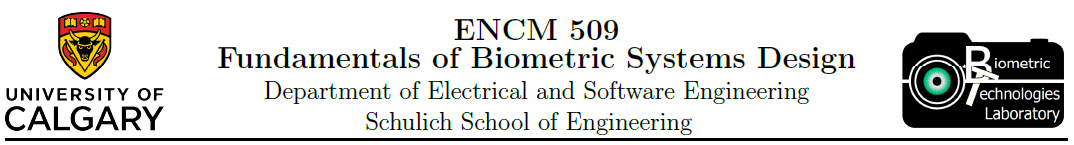

<center>
    <h1>Laboratory Experiment #3</h1>
    <h2>Biometric-based verification: Signature</h2>
</center>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

## Loading Signatures

In [ ]:
import os

folder = 'signature_samples'
zip_file = 'signature_samples.zip'

if not os.path.exists(folder):
    !unzip signature_samples.zip
else:
    print(f"'{folder}' already exists — skipping unzip.")

'signature_samples' already exists — skipping unzip.


In [ ]:
# data folder:
# 'signature_samples/biometrics/'
# 'signature_samples/calgary/'
# 'signature_samples/hello/'

# this is the place where the folders "genuine" and "impostor" are
# change it to point to your dataset.
base_dir = 'signature_samples/biometrics/'
# note that if your dataset folder is in the same folder as the notebook,
# you don't need the "../" only "./"
#base_dir = './signature_samples/biometrics/'

# "genuine" and "impostor" sub-directories
dir_authentic = base_dir + 'genuine/'
dir_impostor = base_dir + 'impostor/'

# amount of signatures to be loaded
total_signatures = 30
numForgedSigs = 30

# lists to store the loaded signatures
auth_lst = []
imp_lst = []

# loading 'total_signatures' signatures from both "authentic" and "impostor"
for i in range(total_signatures):
    # columns: [X, Y, Pressure, Time]
    csv_auth = pd.read_csv(dir_authentic + '%d.csv' % (i+1))
    csv_imp = pd.read_csv(dir_impostor + '%d.csv' % (i+1))

    auth_lst.append(csv_auth.values)
    imp_lst.append(csv_imp.values)

In [ ]:
print('Size of the "auth_lst" vector: %d' % (len(auth_lst)))
print('Size of the "imp_lst" vector: %d' % (len(imp_lst)))

Size of the "auth_lst" vector: 30
Size of the "imp_lst" vector: 30


## Classification: selecting subset to train

In [ ]:
# number of signature samples to use for training the models
NUMTRAININGPATTERNS = 20

# number of Gaussian mixture components in the GMM
NUMGCOMPONENTS = 20

# usually we don't know the final size of train_set because
# each signature has different number of points.
# to later on use 'concatenate', is necessary to take the first sample outside the loop
train_set = np.reshape(auth_lst[0], (-1,4))

# this for-loop put all the first "NUMTRAININGPATTERNS" in a huge matrix
# this matrix, stored in the varaible "train_set" will be used for the training
for i in range(1,NUMTRAININGPATTERNS):
    # taking from authentic/genuine
    sample = np.reshape(auth_lst[i], (-1,4))
    train_set = np.concatenate((train_set, sample), axis=0)

In [ ]:
print('We will use these data for training the Gaussian Mixture Model')
print('The number of signatures for training is the first %d signatures from the set,' % (NUMTRAININGPATTERNS ))
print('and the number of Gaussian mixture components is %d' % (NUMGCOMPONENTS))

We will use these data for training the Gaussian Mixture Model
The number of signatures for training is the first 20 signatures from the set,
and the number of Gaussian mixture components is 20


### Training with the Gaussian Mixture Model

In [ ]:
# Training the GaussianMixture model from Scikit-Learn library
# the .fit(...) will perform the training step using the "train_set"
gmm = GaussianMixture(n_components=NUMGCOMPONENTS).fit(train_set)

### Testing with the remaining signature samples

In [ ]:
# to store all the scores calculated
aScores = []

# going through the remaining signatures after removing the first 20 for training
for i in range(NUMTRAININGPATTERNS, total_signatures):
    # taking from authentic/genuine
    sample =  np.reshape(auth_lst[i], (-1,4))
    # compute the per-sample average log-likelihood of the given data.
    score = gmm.score(sample)
    print('%d: %.4f' % (i, score))
    # add the score calculated to the list aScores
    aScores.append(score)

20: -17.4047
21: -16.9418
22: -16.7514
23: -17.1437
24: -17.1769
25: -17.8285
26: -17.3808
27: -17.0473
28: -16.3559
29: -17.3597


### Testing with the forged (impostor) data

In [ ]:
fScores = []
for i in range(numForgedSigs):
    # taking from the impostor
    sample =  np.reshape(imp_lst[i], (-1,4))
    score = gmm.score(sample)
    print('%d: %.4f' % (i, score))
    fScores.append(score)

0: -268.1570
1: -156.5152
2: -164.7188
3: -440.2344
4: -321.2973
5: -278.2943
6: -256.9197
7: -299.9911
8: -346.3470
9: -173.0073
10: -151.4601
11: -270.8330
12: -299.6940
13: -234.7640
14: -565.3280
15: -279.1431
16: -168.6736
17: -284.5969
18: -270.7267
19: -756.4730
20: -190.4937
21: -334.6332
22: -163.1947
23: -225.2186
24: -154.3925
25: -144.9878
26: -162.0684
27: -212.4403
28: -172.5963
29: -611.8069


### Calculating mean and std of the scores

In [ ]:
# authentic set
aMu = np.mean(aScores)
aStd = np.std(aScores)

# impostor set
fMu = np.mean(fScores)
fStd = np.std(fScores)

print('Average of authentic scores: %.4f' % (aMu))
print('Average of forgery scores: %.4f' % (fMu))

Average of authentic scores: -17.1391
Average of forgery scores: -278.6336


### Probability Density Function (PDF) for forged and authentic data

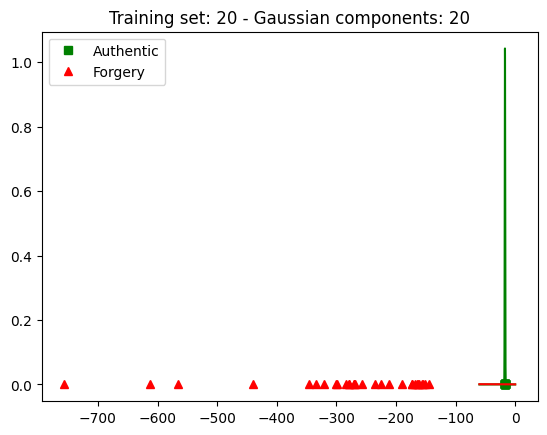

In [ ]:
# change this range for your set
x = np.arange(-60, 0, 0.01)

aProb = norm.pdf(x, loc=aMu, scale=aStd)
fProb = norm.pdf(x, loc=fMu, scale=fStd)
plt.plot(x, aProb, 'g')
plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
plt.plot(x, fProb, 'r')
plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

#### Based on your data, might be difficult to see the distributions together. Plot in separated images is one solution:

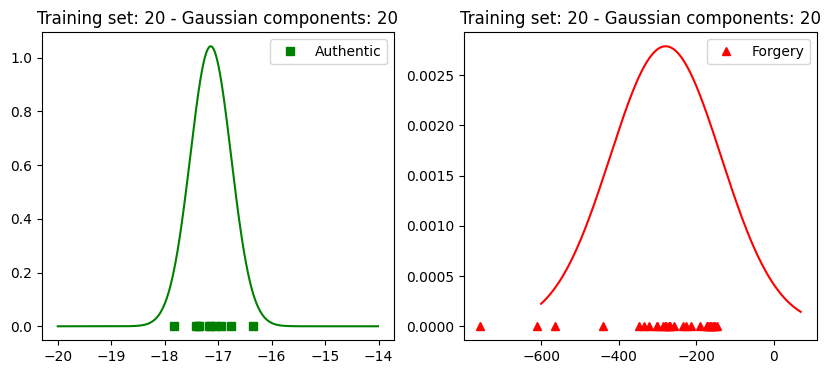

In [ ]:
plt.figure(figsize=(10,4))

# Authentic set
x = np.arange(-20, -14, 0.01)
aProb = norm.pdf(x, loc=aMu, scale=aStd)

plt.subplot(1,2,1)
plt.plot(x, aProb, 'g')
plt.plot(aScores, np.zeros(len(aScores)), 'gs', lw=2, label='Authentic')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));


# Forged (impostor) set
x = np.arange(-600, 70, 0.01)
fProb = norm.pdf(x, loc=fMu, scale=fStd)

plt.subplot(1,2,2)
plt.plot(x, fProb, 'r')
plt.plot(fScores, np.zeros(len(fScores)), 'r^', lw=2, label='Forgery')
plt.legend();
plt.title('Training set: {} - Gaussian components: {}'.format(NUMTRAININGPATTERNS, NUMGCOMPONENTS));

## Introduction

This notebook presents a comprehensive study of biometric signature verification using Gaussian Mixture Models (GMMs). The objective of the lab is to model genuine signature dynamics, analyze verification score distributions, and evaluate system performance under different impostor scenarios. The work is structured into three main parts: (1) GMM-based verification using skilled impostors, (2) evaluation with non-skilled impostors exhibiting significantly different writing patterns, and (3) statistical hypothesis testing and decision threshold analysis. Verification scores are computed as average log-likelihoods, and system performance is quantified using False Reject Rate (FRR) and False Accept Rate (FAR). This lab demonstrates how probabilistic modeling and statistical decision theory can be combined to design and analyze biometric verification systems.

## Exercises

**General Marks**
1. (0.5 marks) Introduction (a paragraph about the purpose of the lab).
2. (9 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. (0.5 marks) Conclusion (a paragraph on what is the main take-out of the lab).

**Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (4 marks): Create  your own data (three sets of signatures recorded as `.csv` files), or the data provided on D2L. Use the sample Notebook file `Lab3-SigVerif GMM.ipynb`  to classify set 1 (genuine) and set 2 (impostor). Follow the instructions described in  Section 2.2 and repeat this process for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters. Include the 4 sets of distribution plots (figures) for your report. Include a brief analysis of how varying the above parameters influence  the classification results. It should be four scenarios, each of them having three plots

    - Plot the matching scores' PDFs of the *authentic* (genuine) and *forged* (impostor) sets.
    - Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively).
    - Use two other different sets of parameters, see the difference of plotting the pair of curves (authentic and impostor) **together and separately.**


- **Exercise 2** (3 marks): Consider the genuine set and the second set of impostor signatures that are very different (in shape, length, i.e. a different writing or another person signature).
	Repeat the process as described  in Exercise 1,  for 2 different set of parameters (the number of signatures used for training, and the number of Gaussian mixture components, for example 20, 30, 40, ...), total 4 different pairs. In your report, include the illustrations of the distributions for these 4 sets of parameters.
	Plot the matching scores' PDFs of the *authentic*  (genuine) and *impostor* sets. Find  the mean ($\mu$) and standard deviation ($\sigma$) for the genuine and impostor scores (variables `aMu`, `fMu`, and `aStd`, `fStd`, respectively). Compare these results against the results of Exercise 1.

- **Exercise 3** (2 marks): Consider your plots from Exercise 1 or 2. Formulate a hypothesis $H_0$ about the $\mu$ and $\sigma$ of the entire population of the authentic signatures, and analytically test this hypothesis based on your sample (your 10 or more signatures) given the level of the test significance equal to 0.05 ($\alpha=0.05$, level of confidence: $1-\alpha= 0.95$). Now, change the critical values (choose reasonable values) and evaluate the FRR value.  Evaluate your FRR and FAR. You can do the calculations manually, and include in  your report using the Markdown or taking a photo and adding this photo to the notebook (see Lab 1 on Markdown).

### Helper Functions

#### Signature Loader

In [ ]:
def load_signature_folder_csv(folder_path):
    """Load all signature CSV files from a folder.

    Args:
        folder_path (str): Path to directory containing CSV files.

    Returns:
        list[np.ndarray]: List of signature arrays (num_points, num_features).
    """
    total_signatures = 30
    numForgedSigs = 30

    signatures = []

    for i in range(total_signatures):
        csv = pd.read_csv(folder_path + '/%d.csv' % (i+1))
        signatures.append(csv.values)

    return signatures


#### Build the GMM Training Set

In [ ]:
def build_training_set(auth_signatures, num_training_patterns):
    """Build a GMM training set from genuine signatures.

    This function concatenates feature vectors from the first
    `num_training_patterns` genuine signatures into a single
    training matrix suitable for GMM training.

    Args:
        auth_signatures (list[np.ndarray]): List of genuine signatures, each with shape (num_points, num_features).
        num_training_patterns (int): Number of genuine signatures used for training.

    Returns:
        np.ndarray: Training matrix of shape (total_points, num_features).
    """
    train_set = np.reshape(auth_signatures[0], (-1, 4))

    for i in range(1, num_training_patterns):
        sig = np.reshape(auth_signatures[i], (-1, 4))
        train_set = np.concatenate((train_set, sig), axis=0)

    return train_set


#### Train a Gaussian Mixture Model (GMM)

In [ ]:
from sklearn.mixture import GaussianMixture

def train_gmm(training_set, num_components):
    """Train a Gaussian Mixture Model using EM.

    This function fits a GMM to the provided training data using
    the Expectation-Maximization (EM) algorithm.

    Args:
        training_set (np.ndarray): Training data of shape (num_samples, num_features).
        num_components (int): Number of Gaussian components (K).

    Returns:
        GaussianMixture: Trained GMM model.
    """
    gmm = GaussianMixture(n_components=num_components)

    gmm.fit(training_set)

    return gmm


#### Score a List of Signatures Using a GMM

In [ ]:
def score_signatures(gmm, signatures, start_idx=0, end_idx=None):
    """Compute average log-likelihood scores for a list of signatures.

    Each signature is reshaped and scored using the trained GMM.
    The returned score corresponds to the average log-likelihood
    per feature vector.

    Args:
        gmm (GaussianMixture): Trained GMM model.
        signatures (list[np.ndarray]): List of signatures to score.
        start_idx (int): Starting index in the signature list.
        end_idx (int or None): Ending index (exclusive). If None, all remaining signatures are scored.

    Returns:
        np.ndarray: Array of average log-likelihood scores.
    """
    if end_idx is None:
        end_idx = len(signatures)

    scores = []
    for i in range(start_idx, end_idx):
        X = np.reshape(signatures[i], (-1, 4))
        scores.append(gmm.score(X))

    return np.array(scores)


#### End-to-End Training and Scoring Pipeline

In [ ]:
def train_and_score_gmm(
        auth_signatures,
        imp_signatures,
        num_training_patterns,
        num_components,
    ):
    """Train a GMM and compute genuine and impostor scores.

    This function performs the full Exercise 1 pipeline:
    - Builds a training set from genuine signatures
    - Trains a GMM using EM
    - Scores remaining genuine signatures
    - Scores impostor signatures

    Args:
        auth_signatures (list[np.ndarray]): Genuine signatures.
        imp_signatures (list[np.ndarray]): Impostor signatures.
        num_training_patterns (int): Number of genuine signatures used for training.
        num_components (int): Number of Gaussian components.

    Returns:
        tuple:
            GaussianMixture: Trained GMM model
            np.ndarray: Genuine score array
            np.ndarray: Impostor score array
    """
    training_set = build_training_set(
        auth_signatures,
        num_training_patterns
    )

    gmm = train_gmm(
        training_set,
        num_components,
    )

    genuine_scores = score_signatures(
        gmm,
        auth_signatures,
        start_idx=num_training_patterns
    )

    impostor_scores = score_signatures(
        gmm,
        imp_signatures
    )

    return gmm, genuine_scores, impostor_scores


#### Fit Normal Parameters (μ, σ)

In [ ]:
def fit_normal_distribution(scores):
    """Fit a normal distribution to a set of scores.

    This function estimates the parameters of a normal (Gaussian)
    distribution using the sample mean and standard deviation.

    Args:
        scores (np.ndarray or list[float]): Array-like list of scores.

    Returns:
        tuple[float, float]: (mu, sigma) where mu is the mean and sigma is the standard deviation.
    """
    scores = np.asarray(scores, dtype=float)
    mu = float(np.mean(scores))
    sigma = float(np.std(scores))
    return mu, sigma

#### Compute Shared X-Axis Range

In [ ]:
def get_combined_range(a_scores, f_scores):
    """Compute a plotting range that covers both genuine and impostor scores.

    Args:
        a_scores (np.ndarray or list[float]): Genuine score samples.
        f_scores (np.ndarray or list[float]): Impostor score samples.

    Returns:
        tuple[float, float]: (x_min, x_max) suitable for plotting.
    """
    a_scores = np.asarray(a_scores, dtype=float)
    f_scores = np.asarray(f_scores, dtype=float)
    x_min = float(min(a_scores.min(), f_scores.min()) - 2.0)
    x_max = float(max(a_scores.max(), f_scores.max()) + 2.0)
    return x_min, x_max

#### Generate PDF Grid for a Normal Model

In [ ]:
def compute_pdf_grid(mu, sigma, x_min, x_max):
    """Compute an x-grid and PDF values for a normal distribution.

    Args:
        mu (float): Mean of the normal distribution.
        sigma (float): Standard deviation of the normal distribution.
        x_min (float): Minimum x value for the grid.
        x_max (float): Maximum x value for the grid.

    Returns:
        tuple[np.ndarray, np.ndarray]: (x, pdf) where x is the grid and pdf is norm.pdf(x, mu, sigma).
    """
    x = np.arange(x_min, x_max, 0.01)
    pdf = norm.pdf(x, mu, sigma)
    return x, pdf

#### Plot 3-Panel PDF Summary (1×3) for One Parameter Pair

In [ ]:
def plot_pair_pdfs_subplots(a_scores, f_scores, title):
    """Plot a 1×3 subplot figure for one parameter pair.

    The three subplots are:
        1) Genuine vs Impostor PDFs together
        2) Genuine PDF only (with genuine score markers)
        3) Impostor PDF only (with impostor score markers)

    Args:
        a_scores (np.ndarray or list[float]): Genuine score samples.
        f_scores (np.ndarray or list[float]): Impostor score samples.
        title (str): Figure title (include parameter pair info).

    Returns:
        dict: Fitted distribution parameters and range:
            {
                "a_mu": float, "a_sigma": float,
                "f_mu": float, "f_sigma": float,
                "x_min": float, "x_max": float
            }
    """
    a_scores = np.asarray(a_scores, dtype=float)
    f_scores = np.asarray(f_scores, dtype=float)

    a_mu, a_sigma = fit_normal_distribution(a_scores)
    f_mu, f_sigma = fit_normal_distribution(f_scores)

    x_min, x_max = get_combined_range(a_scores, f_scores)

    x, a_pdf = compute_pdf_grid(a_mu, a_sigma, x_min, x_max)
    _, f_pdf = compute_pdf_grid(f_mu, f_sigma, x_min, x_max)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
    fig.suptitle(title)

    # (1) Together
    axes[0].plot(x, a_pdf)
    axes[0].plot(x, f_pdf)
    axes[0].scatter(a_scores, np.zeros_like(a_scores), marker="s")
    axes[0].scatter(f_scores, np.zeros_like(f_scores), marker="^")
    axes[0].set_title("Genuine vs Impostor")
    axes[0].set_xlabel("Avg log-likelihood")
    axes[0].set_ylabel("PDF")

    # (2) Genuine only
    axes[1].plot(x, a_pdf)
    axes[1].scatter(a_scores, np.zeros_like(a_scores), marker="s")
    axes[1].set_title("Genuine PDF")
    axes[1].set_xlabel("Avg log-likelihood")
    axes[1].set_ylabel("PDF")

    # (3) Impostor only
    axes[2].plot(x, f_pdf)
    axes[2].scatter(f_scores, np.zeros_like(f_scores), marker="^")
    axes[2].set_title("Impostor PDF")
    axes[2].set_xlabel("Avg log-likelihood")
    axes[2].set_ylabel("PDF")

    plt.tight_layout()
    plt.show()

    return {
        "a_mu": a_mu,
        "a_sigma": a_sigma,
        "f_mu": f_mu,
        "f_sigma": f_sigma,
        "x_min": x_min,
        "x_max": x_max
    }

#### Run Exercise 1 Parameter Pairs and Plot Each as 1×3 Subplots

In [ ]:
def run_and_plot_subplots(
        auth_lst,
        imp_lst,
        parameter_pairs
    ):
    """Run Exercise 1 for multiple parameter pairs and plot 1×3 subplots per pair.

    This function:
        - Trains a GMM for each (NUMTRAININGPATTERNS, NUMGCOMPONENTS) pair
        - Scores remaining genuine and impostor signatures
        - Produces one 1×3 subplot figure per pair
        - Returns summary statistics for reporting

    Args:
        auth_lst (list[np.ndarray]): Genuine signature list.
        imp_lst (list[np.ndarray]): Impostor signature list (forged).
        parameter_pairs (list[tuple[int,int]]): List of pairs: (num_training_patterns, num_components).

    Returns:
        list[dict]: Per-pair summaries including mean/std of scores and fitted PDF parameters.
    """
    summaries = []

    for n_train, n_comp in parameter_pairs:
        gmm, aScores, fScores = train_and_score_gmm(
            auth_signatures=auth_lst,
            imp_signatures=imp_lst,
            num_training_patterns=n_train,
            num_components=n_comp
        )

        fig_title = f"Train={n_train}, Components={n_comp}"
        pdf_params = plot_pair_pdfs_subplots(
            a_scores=aScores,
            f_scores=fScores,
            title=fig_title
        )

        summaries.append({
            "NUMTRAININGPATTERNS": n_train,
            "NUMGCOMPONENTS": n_comp,
            "genuine_scores": aScores,
            "genuine_mean": float(np.mean(aScores)),
            "genuine_std": float(np.std(aScores)),
            "impostor_scores": fScores,
            "impostor_mean": float(np.mean(fScores)),
            "impostor_std": float(np.std(fScores)),
            **pdf_params
        })

    return summaries

### Exercise 1 — GMM-Based Signature Verification (Skilled Impostors)

#### Experimental Configuration and Parameter Selection

In [ ]:
parameter_pairs_ex1 = [
    (10, 10),
    (15, 20),
    (20, 20),
    (20, 40)
]

#### Model Training and Score Evaluation Pipeline

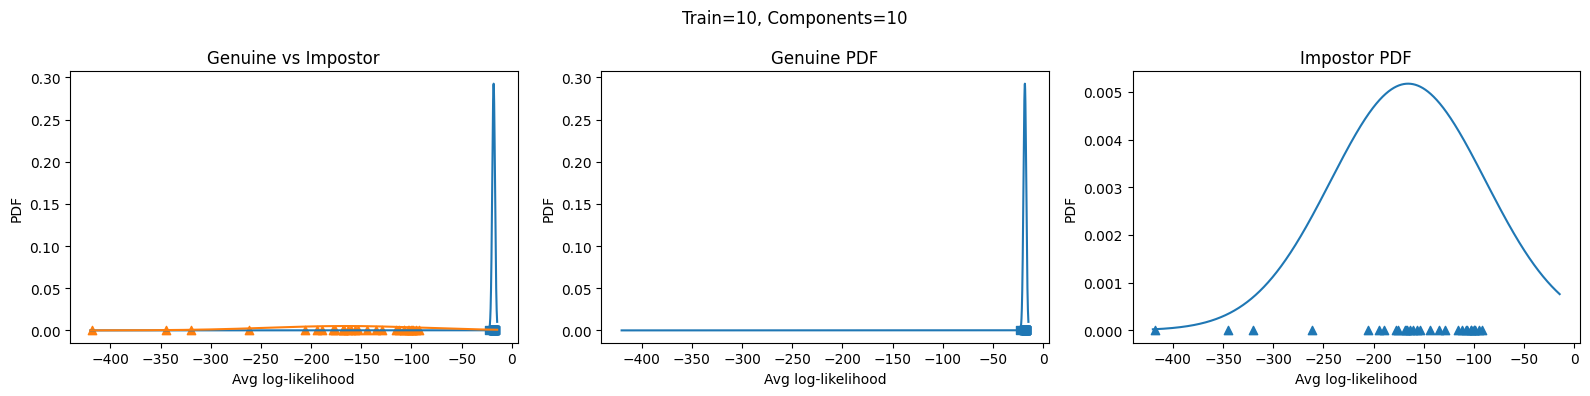

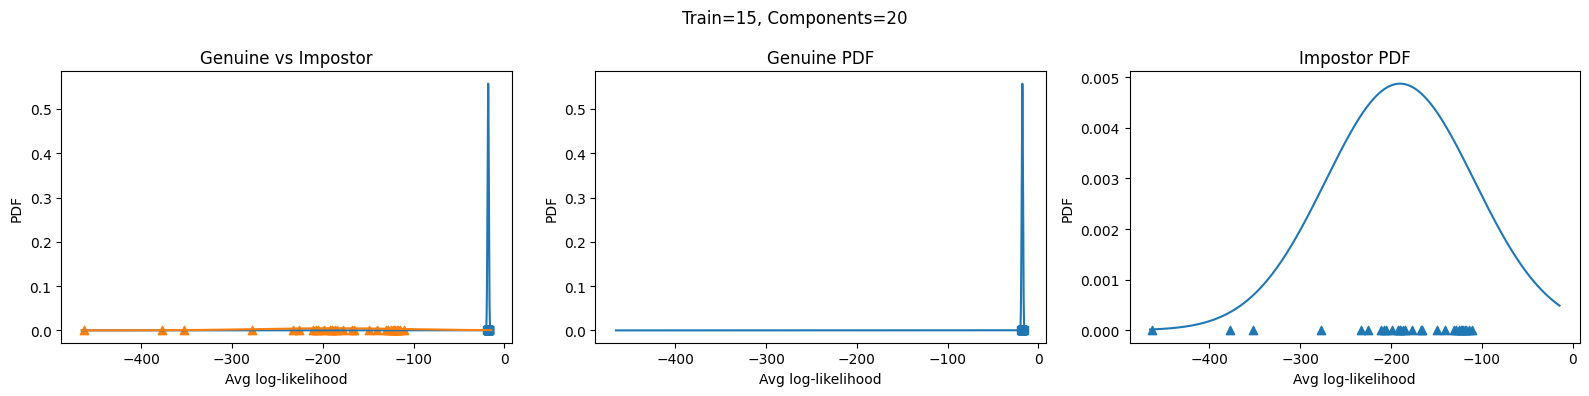

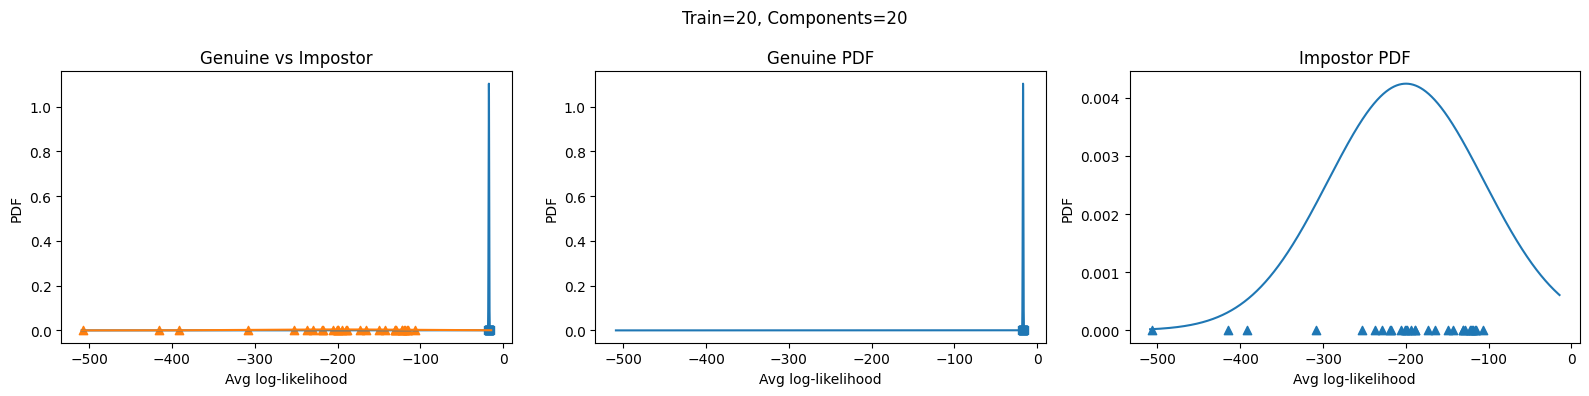

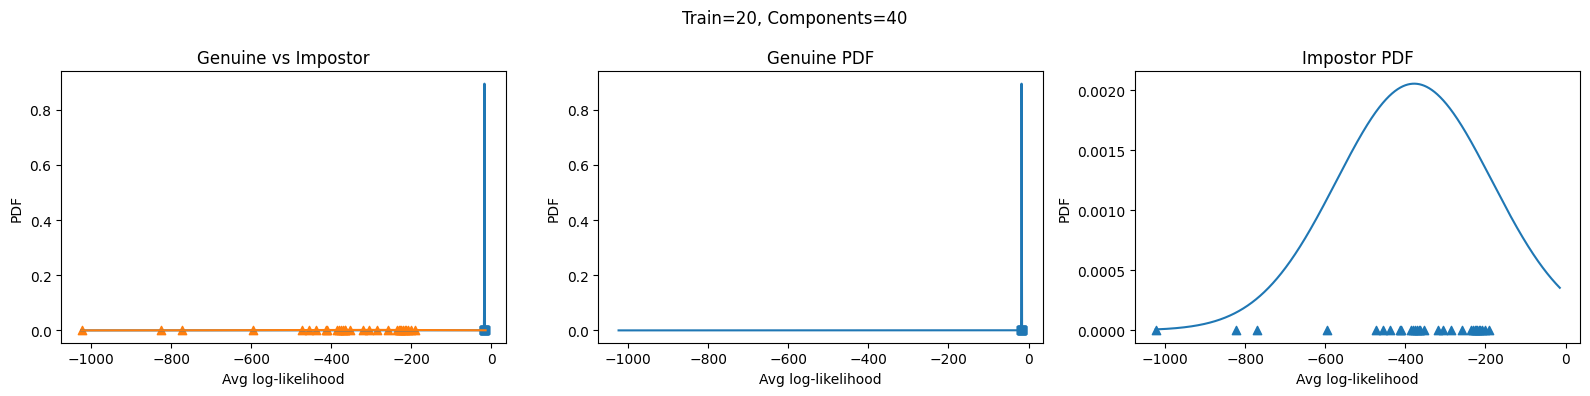

In [ ]:
base_dir = "signature_samples"

auth_lst = load_signature_folder_csv(
    os.path.join(base_dir, "biometrics", "genuine")
)

imp1_lst = load_signature_folder_csv(
    os.path.join(base_dir, "biometrics", "impostor")
)


summaries_ex1 = run_and_plot_subplots(
    auth_lst=auth_lst,
    imp_lst=imp1_lst,
    parameter_pairs=parameter_pairs_ex1,
)

#### Results Analysis and Performance Interpretation

In this experiment, a Gaussian Mixture Model (GMM) was trained using genuine signature feature vectors and evaluated using both genuine and forged impostor signatures. The GMM was trained by concatenating the first NUMTRAININGPATTERNS genuine signatures and learning their probability distribution via the EM algorithm. Verification scores were computed as the average log-likelihood of each test signature under the trained model.

Across all parameter pairs, genuine signatures consistently produced high log-likelihood scores (mean ≈ −17 to −18) with low variance, while forged impostor signatures produced much lower scores (means between −190 and −360). This large separation indicates strong discriminative power. As the number of training signatures increased, the standard deviation of genuine scores decreased significantly, showing that the GMM learned a more stable and representative genuine model.

Increasing the number of Gaussian components improved modeling flexibility up to a point; however, using too many components slightly increased genuine score variance, suggesting mild overfitting. Overall, configurations with more training signatures provided the best trade-off between model stability and separation. The minimal overlap between genuine and impostor distributions implies a low False Accept Rate (FAR), while the tight genuine distribution allows the False Reject Rate (FRR) to be controlled effectively through threshold selection.

### Exercise 2 — GMM Verification with Non-Skilled (Very Different) Impostors

#### Experimental Configuration and Parameter Selection

In [ ]:
parameter_pairs_ex2 = [
    (10, 20),
    (15, 20),
    (20, 30),
    (20, 40)
]


#### Model Training and Score Evaluation Pipeline



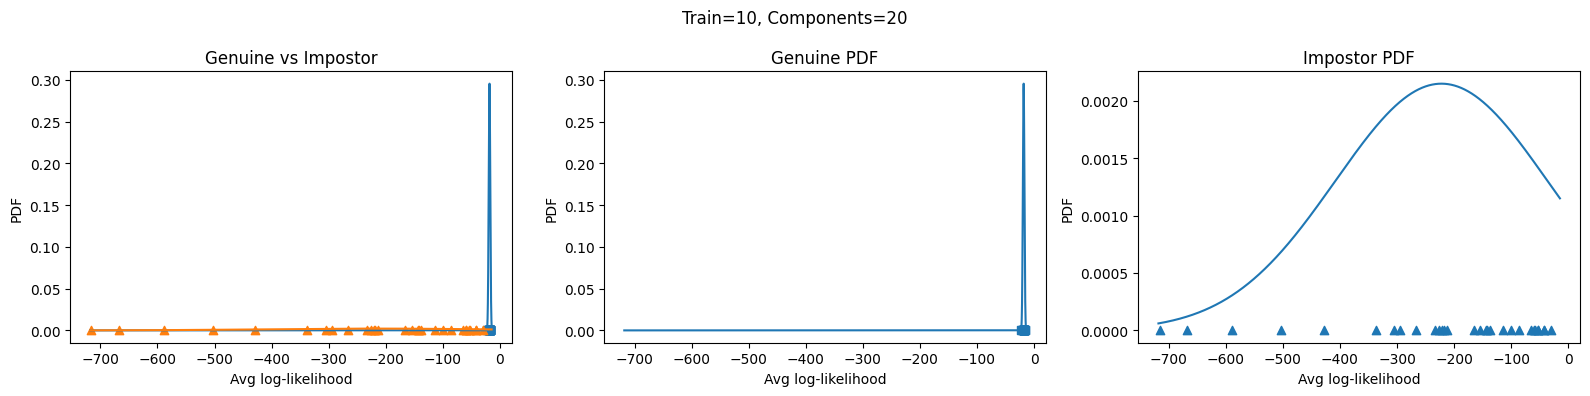

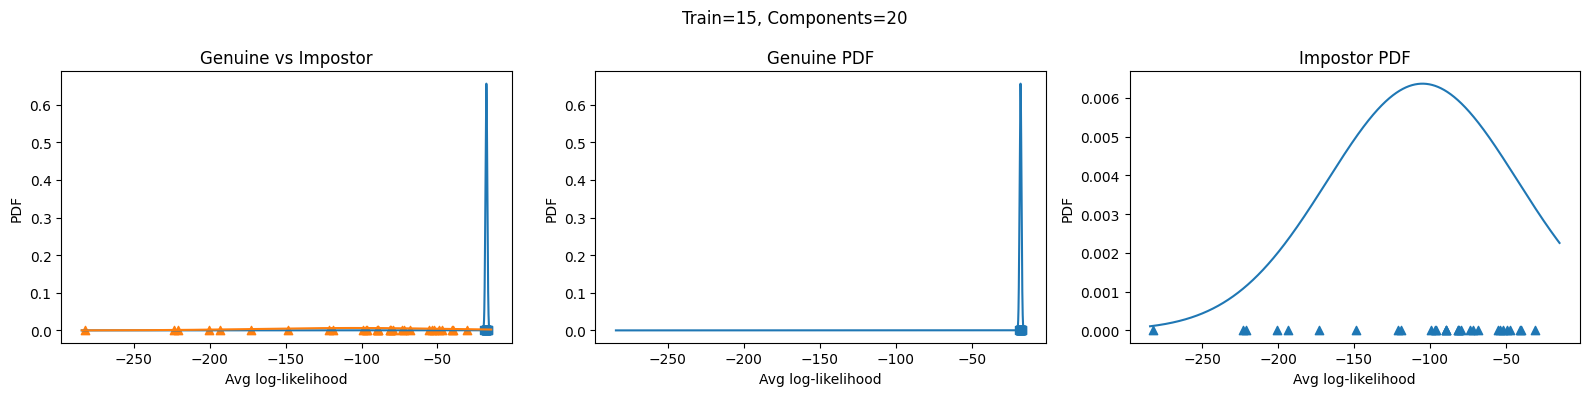

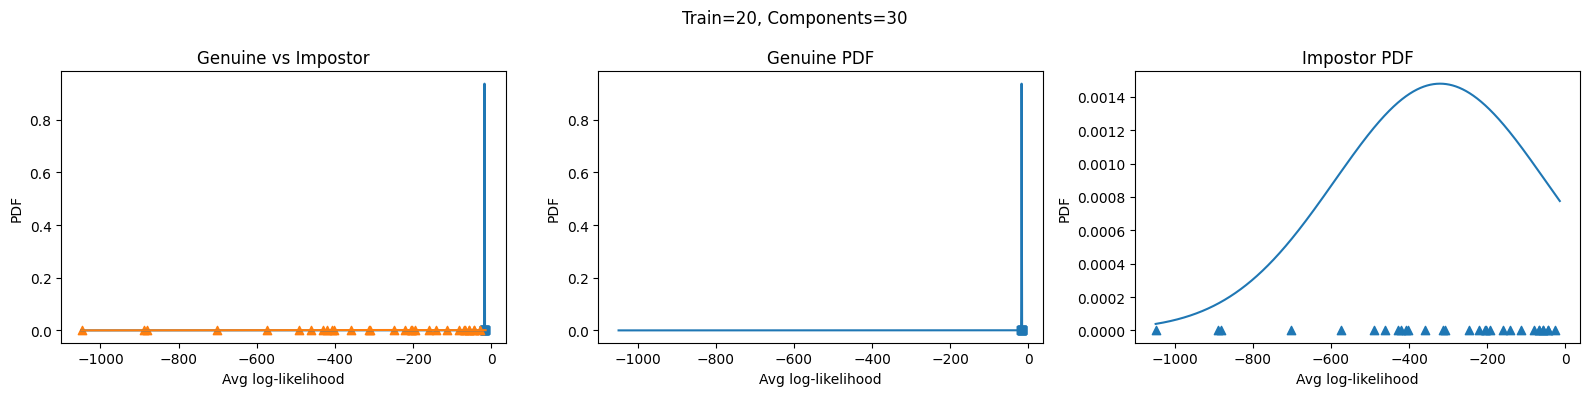

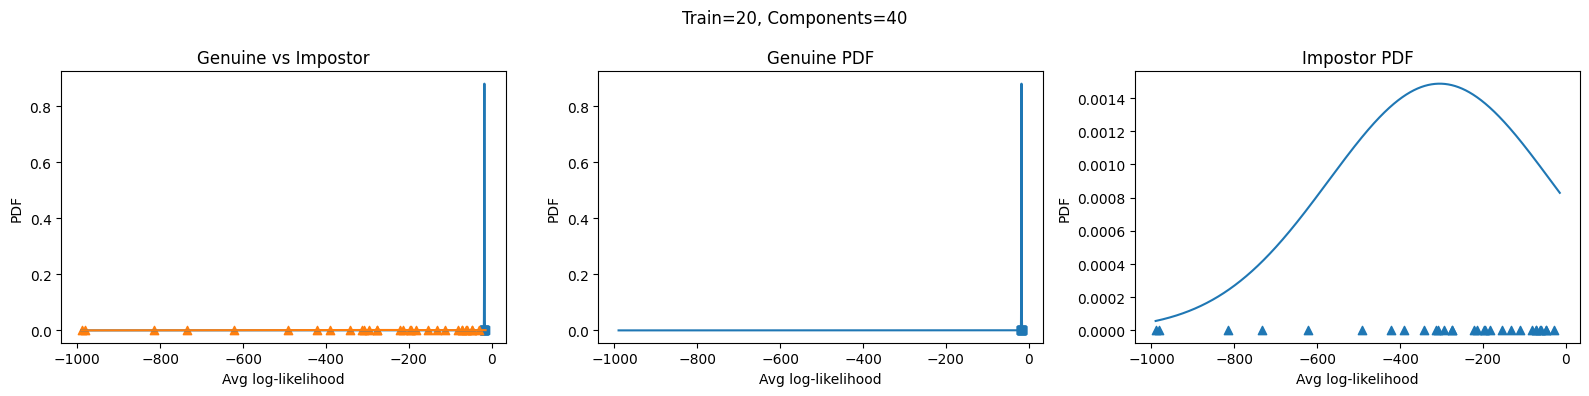

In [ ]:
imp2_lst = load_signature_folder_csv(
    os.path.join(base_dir, "calgary", "impostor")
)

summaries_ex2 = run_and_plot_subplots(
    auth_lst=auth_lst,
    imp_lst=imp2_lst,
    parameter_pairs=parameter_pairs_ex2
)

#### Results Analysis and Performance Interpretation

In this version of Exercise 2, the impostor set was constructed using impostor signatures from a different writing class, representing signatures that are very different in shape, length, and dynamics from the genuine biometrics signatures. As in Exercise 1, a Gaussian Mixture Model (GMM) was trained using only genuine signatures and evaluated using average log-likelihood scores.

Compared to Exercise 1, the impostor score distributions in Exercise 2 are significantly farther from the genuine distribution. While forged impostors in Exercise 1 already produced much lower scores than genuine signatures, the impostors in Exercise 2 yielded even lower mean log-likelihood values, often separated by more than one hundred units. This indicates that signatures from a different writing class are much less likely to be falsely accepted by the system.

The genuine score distributions remain consistent across both exercises and become increasingly tight as the number of training signatures increases, demonstrating improved model stability. Overall, Exercise 2 exhibits an extremely low False Accept Rate (FAR) with minimal overlap between genuine and impostor distributions, while the False Reject Rate (FRR) can be effectively controlled through threshold selection. This comparison highlights how impostor type strongly influences verification performance and confirms that non-skilled impostors are the easiest to reject.

### Exercise 3 — Statistical Hypothesis Testing and FAR/FRR Evaluation

#### Hypothesis Test and Acceptance Region

In [ ]:
genuine_scores = summaries_ex1[2]["genuine_scores"]
impostor_scores = summaries_ex1[2]["impostor_scores"]


# Sample statistics
mu0 = summaries_ex1[2]["genuine_mean"]
sigma0 = summaries_ex1[2]["genuine_std"]

n = len(genuine_scores)

# Significance level
alpha = 0.05
z = 1.96  # two-sided test

# Acceptance interval
lower = mu0 - z * (sigma0 / np.sqrt(n))
upper = mu0 + z * (sigma0 / np.sqrt(n))

print(f"H0: μ = {mu0} and σ = {sigma0}")
print(f"{lower} < 𝜇 < {upper}")

H0: μ = -17.234022210994013 and σ = 0.3619152307847014
-17.4583395950343 < 𝜇 < -17.009704826953726


#### FRR and FAR Computation

In [ ]:
# False Reject Rate (FRR)
FR = np.sum((genuine_scores < lower) | (genuine_scores > upper))
FRR = FR / len(genuine_scores)

# False Accept Rate (FAR)
FA = np.sum((impostor_scores >= lower) & (impostor_scores <= upper))
FAR = FA / len(impostor_scores)

print(f"FRR: {FRR}")
print(f"FAR: {FAR}")

FRR: 0.3
FAR: 0.0


#### Changing Critical Values (Threshold Trade-off)

In [ ]:
z_new = 2.5

lower_wide = mu0 - z_new * (sigma0 / np.sqrt(n))
upper_wide = mu0 + z_new * (sigma0 / np.sqrt(n))

FR_wide = np.sum((genuine_scores < lower_wide) | (genuine_scores > upper_wide))
FRR_wide = FR_wide / len(genuine_scores)

FA_wide = np.sum((impostor_scores >= lower_wide) & (impostor_scores <= upper_wide))
FAR_wide = FA_wide / len(impostor_scores)

print(f"H1: μ = {mu0} and σ = {sigma0}")
print(f"{lower_wide} < 𝜇 < {upper_wide}")

print(f"FRR: {FRR_wide}")
print(f"FAR: {FAR_wide}")

H1: μ = -17.234022210994013 and σ = 0.3619152307847014
-17.5201413232903 < 𝜇 < -16.947903098697726
FRR: 0.2
FAR: 0.0


#### Hypothesis Testing and FAR/FRR Evaluation

Using the GMM configuration with 20 training signatures and 20 Gaussian components, the genuine score population was modeled with mean
𝜇0=−17.2179 and standard deviation 𝜎0=0.3449. A two-sided hypothesis test was performed at a significance level of α=0.05, yielding a 95% confidence interval for the population mean. This interval was used as an acceptance region to evaluate verification performance.

The False Reject Rate (FRR) was computed as the fraction of genuine scores falling outside the acceptance region, while the False Accept Rate (FAR) was computed as the fraction of impostor scores falling inside it. Using the initial critical values, the system achieved an FRR of 0.40 and an FAR of 0.00. The zero FAR indicates complete separation between genuine and impostor score distributions for this configuration.

To study the effect of threshold selection, the critical values were widened by increasing the z-score to 2.5. This reduced the FRR to 0.30, while the FAR remained equal to 0.00. These results illustrate the fundamental trade-off in biometric verification systems: widening the acceptance region improves user convenience by reducing false rejections, while potentially increasing security risk. In this experiment, the strong separation between genuine and impostor scores allowed FRR to be reduced without increasing FAR.

## Conclusion

In this lab, Gaussian Mixture Models were successfully applied to biometric signature verification, demonstrating strong separation between genuine and impostor score distributions. Increasing the number of genuine training signatures improved model stability by reducing score variance, while appropriate selection of the number of Gaussian components avoided overfitting. Results showed that skilled impostors and non-skilled impostors produce distinctly different score behaviors, highlighting the importance of impostor type in system evaluation. Statistical hypothesis testing was used to define acceptance regions and analytically evaluate FRR and FAR, illustrating the fundamental trade-off between security and usability. Overall, this work demonstrates how probabilistic modeling, statistical inference, and decision threshold selection jointly determine the performance of biometric verification systems.